# Coursework 2: Image Classification

In this coursework, you are going to develop a neural network model for for image classification.

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and text answers, and upload the pdf file onto [Cate](https://cate.doc.ic.ac.uk).

## Dependencies:

If you do not have Jupyter-Lab on your laptop, you can find information for installing Jupyter-Lab [here](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html).

There may be certain Python packages you may want to use for completing the coursework. We have provided examples below for importing libraries. If some packages are missing, you need to install them. In general, new packages (e.g. imageio etc) can be installed by running 

`pip3 install [package_name]`

in the terminal. If you use Anaconda, you can also install new packages by running `conda install [package_name]` or using its graphic user interface.

In [1]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a training set of 60,000 images and a test set of 10,000 images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:

| Label       | Description |
| ----------- | ----------- |
| 0  |  T-shirt/top |
| 1  |  Trousers    |
| 2  |  Pullover    |
| 3  |  Dress       |
| 4  |  Coat        |
| 5  |  Sandal      |
| 6  |  Shirt       |
| 7  |  Sneaker     |
| 8  |  Bag         |
| 9  |  Ankle boot  |

In [2]:
# Load data (provided)
# Note that some early versions of torchvision use different names, such as train_data, test_data instead of data.
# However, after torchvision version 0.4.0, data is used as the variable name.
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
#dimension of the training set
print("The dimension of the train set is",train_image.shape)
print("The dimension of the train label is",train_label.shape)


#dimension of the test set
print("The dimension of the test set is",test_image.shape)
print("The dimension of the test label is",test_label.shape)



The dimension of the train set is (60000, 28, 28)
The dimension of the train label is (60000,)
The dimension of the test set is (10000, 28, 28)
The dimension of the test label is (10000,)


### 1.2 Visualise sample images for each of the 10 classes. (5 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

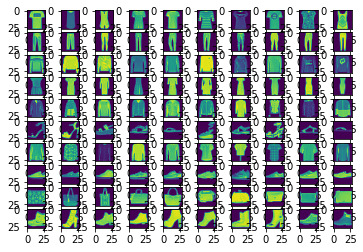

In [4]:
#get 10 samples of each class
image_num=1

#for each class
for i in range(len(class_name)):
    index_image=np.where(train_label==i)[0][:10]
    #get 10 samples
    for j in range(10):
        plt.subplot(10,10,image_num)
        image_num+=1
        plt.imshow(train_image[index_image[j],:,:])
    
    

### 1.3 Display the number of training samples for each class. (5 marks)

In [5]:
count=np.zeros(len(class_name))
for i,classname in enumerate(class_name):
    count[i]=np.sum(train_label==i)
    print("the number of class ",classname,"is",count[i])

the number of class  T-shirt/top is 6000.0
the number of class  Trouser is 6000.0
the number of class  Pullover is 6000.0
the number of class  Dress is 6000.0
the number of class  Coat is 6000.0
the number of class  Sandal is 6000.0
the number of class  Shirt is 6000.0
the number of class  Sneaker is 6000.0
the number of class  Bag is 6000.0
the number of class  Ankle boot is 6000.0


### 1.4 Discussion. (10 marks)

Is the dataset balanced? Would you prefer a balanced or unbalanced dataset? Explain why?

 This a balanced dataset, because each of the classes has 6000 samples.

I would prefer a banlanced dataset, because if the dataset is not balanced, it would influnce the performance of the model, specifically for the minority class. If you use an unbalanced dataset, the training result would be influneced by the majority class. For example, if you have
100 traning examples, 99 are bags, 1 is coat, and you want to classify coat and  bag. Because the majority of the training 
 set are the bags so the model would told you it is a bag whatever you input to it. In the training set if you predict 
 everything as a bag, the accuracy would be 99%, which is a good accuracy, but this model can not classify the bag and coat at all,specifically for the coat.


## 2. Image classification. (55 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can design a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
####input is 28*28 not 32*32, so the dimension may be different from the figure above

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #conv layer
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fully connected layer
        #input is 28*28 not 32*32, so the dimension may be different from the figure above
        # it is  4*4 
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        
        #pooing layer
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        #flatten x 
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

# Network
model = Net().to(device)

#the structure of the net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [7]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

#Because it is a multi-class classifier, so I use cross entropy as the loss function
criterion = nn.CrossEntropyLoss()

# I use sGD as the optimiser
#learning rate is 0.001 
optimizer = optim.SGD(net.parameters(), lr=0.001)

#epoch=10
epoch_num=10

#batch size=20
batch_size=20

#batch_num
batch_num=int(train_image.shape[0]/batch_size)

print("The number of batch is :",batch_num)



The number of batch is : 3000


### 2.3 Start model training. (15 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent.

Print out training loss and training time.

In [8]:
#convert numpy to tensor
# Expand the train dimension of the numpy array

expand_train_image=train_image.reshape(train_image.shape[0],1,train_image.shape[1],train_image.shape[2])
print("Now the demension of the train_image is",expand_train_image.shape)

# Convert to a Pytorch tensor 
torch_train_image=torch.from_numpy(expand_train_image).float()
torch_train_label=torch.from_numpy(train_label)

#training
for epoch in range(epoch_num):
    
    for batch in range(batch_num):
      batch_x, batch_y = torch_train_image[batch*batch_size:(batch+1)*batch_size,], torch_train_label[batch*batch_size:(batch+1)*batch_size,]
    
    #forward
      prediction = net(batch_x)
      loss = criterion(prediction, batch_y)
    
    #clear the gradient buffer
      optimizer.zero_grad()
        
    #backward
      loss.backward() 
        
    #update paramenter
      optimizer.step() 
    print('\repoch: {}\tbatch: {}\tLoss =  {:.3f}'.format(epoch, batch, loss))

Now the demension of the train_image is (60000, 1, 28, 28)
epoch: 0	batch: 2999	Loss =  0.522
epoch: 1	batch: 2999	Loss =  0.459
epoch: 2	batch: 2999	Loss =  0.389
epoch: 3	batch: 2999	Loss =  0.325
epoch: 4	batch: 2999	Loss =  0.323
epoch: 5	batch: 2999	Loss =  0.301
epoch: 6	batch: 2999	Loss =  0.288
epoch: 7	batch: 2999	Loss =  0.283
epoch: 8	batch: 2999	Loss =  0.269
epoch: 9	batch: 2999	Loss =  0.254


### 2.4 Deploy the trained model onto the test set. (10 marks)

Please also evaluate how long it takes for testing.

In [9]:
import time

# Expand the test dimension of the numpy array
expand_test_image=test_image.reshape(test_image.shape[0],1,test_image.shape[1],test_image.shape[2])
print("Now the demension of the train_image is",expand_test_image.shape)

# Convert to a Pytorch tensor 
torch_test_image=torch.from_numpy(expand_test_image).float()

#compute the time
start = time.time()
prediction=net(torch_test_image)
duration=time.time()-start

print("The time it use to predict the test set is: ",duration)

Now the demension of the train_image is (10000, 1, 28, 28)
The time it use to predict the test set is:  0.9599978923797607


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [10]:
# choose the class of the largest value as predicted class
prediction_class=prediction.argmax(dim=1)
prediction_class=np.array(prediction_class)

#accuracy
accuracy=np.sum(prediction_class==test_label)/len(test_label)
print("The accuracy of the leNet is :",accuracy)

The accuracy of the leNet is : 0.8787


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [11]:
conf_matrix=metrics.confusion_matrix(test_label, prediction_class)
print("The confusion matrix of the model is: ")
print(conf_matrix)

The confusion matrix of the model is: 
[[814   0  24  45  12   3  90   0  12   0]
 [  0 954   0  37   2   0   4   0   3   0]
 [ 11   0 787  11  99   0  90   0   2   0]
 [ 11   3   8 920  24   0  30   0   4   0]
 [  1   2  64  40 813   0  76   0   4   0]
 [  0   0   0   0   0 968   0  19   1  12]
 [134   1  85  39  76   0 647   0  18   0]
 [  0   0   0   0   0  26   0 949   1  24]
 [  4   0   7   5   3   2   4   5 970   0]
 [  0   0   0   0   0   5   1  29   0 965]]


## 3. Deploy in real world. (20 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use Python or any other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28. You do not need to show the pre-processing step in this coursework.

### 3.1 Load and visualise your own images. (5 marks)

In [12]:

import numpy as np
from PIL import Image
from skimage import data, exposure, img_as_float, transform
import os

#data processing
images = ["trouser.jpg", "ankle_boot.jpg", "T-shirt.jpg"]

for image in images:
    img = np.array(Image.open(image))

    # gray
    im = Image.fromarray(img)
    im = im.convert('L')
    im = np.array(im)


    # negate
    im = Image.fromarray(-np.array(im))
    im = im.convert('L')
    im = np.array(im)

    #crop
    im = np.array(im)
    img = Image.fromarray(im)
    img = img.resize((28, 28))

    img.save('intensities-' + image)



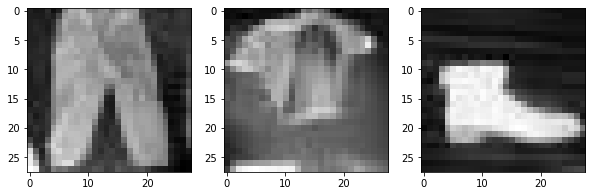

In [13]:
import imageio
from PIL import Image

#load the image
t_shirt=np.array(Image.open('intensities-T-shirt.jpg'))
trouser=np.array(Image.open('intensities-trouser.jpg'))
ankle_boot=np.array(Image.open('intensities-ankle_boot.jpg'))


#show the plot
plt.subplot(1,3,1)
plt.imshow(trouser, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(t_shirt, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(ankle_boot, cmap='gray')
plt.gcf().set_size_inches(10, 8)

### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [14]:

# expand and Convert to a Pytorch tensor 

t_shirt=t_shirt.reshape(1,1,28,28)

trouser=trouser.reshape(1,1,28,28)

ankle_boot=ankle_boot.reshape(1,1,28,28)

torch_t_shirt=torch.from_numpy(t_shirt).float()

torch_trouser=torch.from_numpy(trouser).float()

torch_ankle_boot=torch.from_numpy(ankle_boot).float()

prediction=net(torch_t_shirt)
print("The class of t-shirt it predict is: ",class_name[int(prediction.argmax(dim=1))])

prediction=net(torch_trouser)
print("The class of trouser it predict is is: ",class_name[int(prediction.argmax(dim=1))])

prediction=net(torch_ankle_boot)
print("The class of ankel-boot it predict isis: ",class_name[int(prediction.argmax(dim=1))])


The class of t-shirt it predict is:  T-shirt/top
The class of trouser it predict is is:  Trouser
The class of ankel-boot it predict isis:  Bag


### 3.3 Comment on the classification results. (10 marks)

Does the model work? Is there anyway to improve the real life performance of the model?

Although the model predicts well in the test set, it predicts two correct answers and one wrong answer using the real life pictures. Therefore, I think it is not very accuracte to predict real clothes. 
- In my opinion, one reason is that there are millions of even billions of styles of clothes in real life, which is more larger than the training set. Even they are all ankle-boots, they have different shaps, patterns ,etc. Training data set don't have all kinds of clothes, so they may miserable classsify some clothes. One solution to that is to extand your training dataset, maybe use millions of picture or even more.
- Also, the picture in the train set clothes are all in the middle, and their directions are all vertical, not sideways. However in the real word, pictures of clothes may in different angles and the clothes may not in the right middle and their directions may be different. So in order to detect clothes in the real world, we need to do some data augmentation(rotate the picture, do some translation, take the picture in different angles, etc.) 
- Add more layers to make the network deeper gives the model more power to learn the complex pattern in the real life.
- Make the CNN training longer(more epochs), train a long time also gives it possibility to learn complex pattern.
- Maybe find a better the activation funtion or a better optimiser, which is suitable for the task may be also help

## 4. Survey: How long does it take you to complete the coursework?

In [15]:
#4 hours